In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as keras

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# data preparation for Rao
from prepare_data import *

In [3]:
import sys
sys.path.insert(0, os.getcwd().rsplit('/',1)[0])

import loops_utils

# load unet model
from unet_model import *

In [4]:
%matplotlib inline

## select mask with diagonal

In [7]:
image_size = 256
X_train, y_train = prepare_data(image_size, chromosomes_idx=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,'X','Y'], is_mask_corner_peak=True)  
X_valid, y_valid = prepare_data(image_size, chromosomes_idx=[17,18,19,20], is_mask_corner_peak=True) 

/Users/alex/Desktop/ws/hse/diploma/loops/rao/prepare_data.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loops = loops_filtered[loops_info.chr1 == str(chr_num)]


/Users/alex/Desktop/ws/hse/diploma/loops/loops_utils.py:74: RuntimeWarning: divide by zero encountered in log
  raw = np.log(raw)


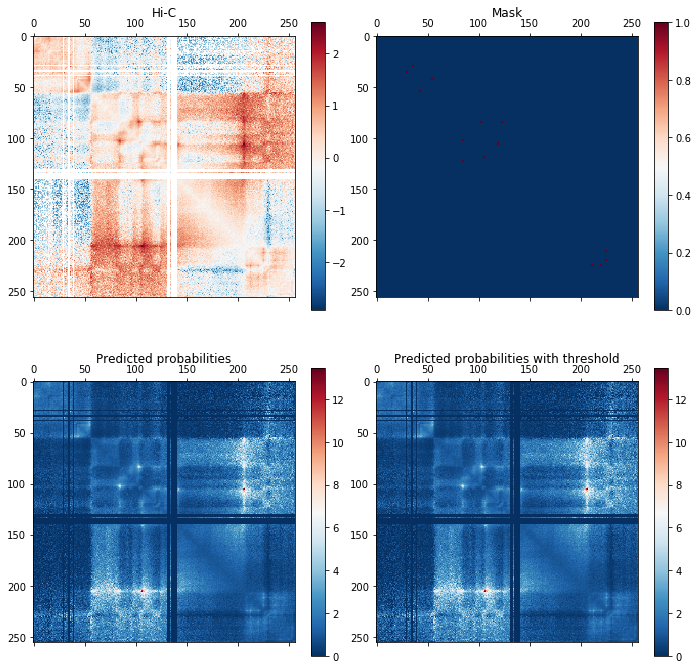

In [13]:
loops_utils.plot_prediction_HiC(X_train[1,:,:,:],
                                y_train[1,:,:,:],
                                X_train[1,:,:,:],
                                X_train[1,:,:,:],
                                image_size=256)

In [12]:
np.save('prepared_datasets/X_train', X_train)
np.save('prepared_datasets/y_train', y_train)
np.save('prepared_datasets/X_valid', X_valid)
np.save('prepared_datasets/y_valid', y_valid)

In [6]:
input_img = Input((image_size, image_size, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

weights_path = 'weights/model_unet_' + str(image_size) + '.h5'

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
callbacks = [
        EarlyStopping(patience=10, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
        ModelCheckpoint(weights_path, verbose=1, save_best_only=True, save_weights_only=True)]

In [8]:
results = model.fit(X_train, y_train, batch_size=1, epochs=100, callbacks=callbacks, 
                        validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 1069 samples, validate on 112 samples
Epoch 1/100
1069/1069 [==============================] - 1369s 1s/step - loss: 0.1899 - acc: 0.9251 - val_loss: 0.1605 - val_acc: 0.9228

Epoch 00001: val_loss improved from inf to 0.16053, saving model to weights/model_unet_256.h5
Epoch 2/100
1069/1069 [==============================] - 1312s 1s/step - loss: 0.1242 - acc: 0.9492 - val_loss: 0.1227 - val_acc: 0.9529

Epoch 00002: val_loss improved from 0.16053 to 0.12274, saving model to weights/model_unet_256.h5
Epoch 3/100
1069/1069 [==============================] - 1238s 1s/step - loss: 0.1134 - acc: 0.9531 - val_loss: 0.1226 - val_acc: 0.9510

Epoch 00003: val_loss improved from 0.12274 to 0.12260, saving model to weights/model_unet_256.h5
Epoch 4/100
1069/1069 [==============================] - 1299s 1s/step - loss: 0.1037 - acc: 0.9578 - val_loss: 0.1285 - val_acc: 0.9484

Epoch 00004: val_loss did not improve from 0.12260
Epoch 5/100


In [19]:
plot_model_scores(results, figsize=(10,10), name='unet_rao_learning_curve_1')

TypeError: plot_model_scores() got an unexpected keyword argument 'figsize'

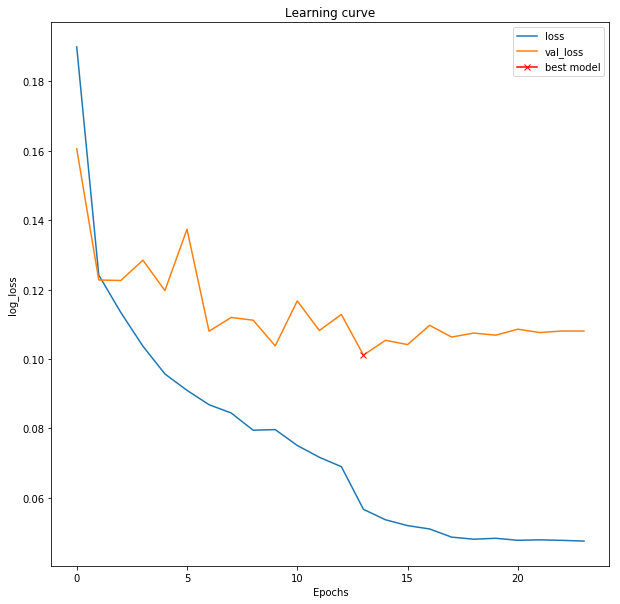

In [21]:
plt.figure(figsize=(10,10))
plt.title('Learning curve')
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label='val_loss')
plt.plot( np.argmin(results.history['val_loss']), np.min(results.history['val_loss']), marker='x', color='r', label='best model')
plt.xlabel('Epochs')
plt.ylabel('log_loss')
plt.legend()

plt.savefig('pictures/unet_rao_learning_curve_1.png')
        
        

In [10]:
model.load_weights(weights_path)
X_test, y_test = prepare_data(image_size, chromosomes_idx=[21, 22]) 
score, acc = model.evaluate(X_test, y_test, verbose=1)

40/40 [==============================] - 8s 201ms/step


In [11]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.05297873318195343
Test accuracy: 0.9783760070800781


In [12]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

40/40 [==============================] - 8s 198ms/step


In [31]:
metrics.accuracy_score(y_test.ravel(), preds_test_t.ravel())

0.9783760070800781

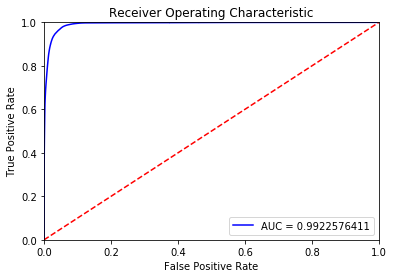

In [32]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_test.ravel(), preds_test.ravel())
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.10f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Train example 1


/Users/alex/Desktop/ws/hse/diploma/loops/loops_utils.py:62: RuntimeWarning: divide by zero encountered in log
  raw = np.log(raw)


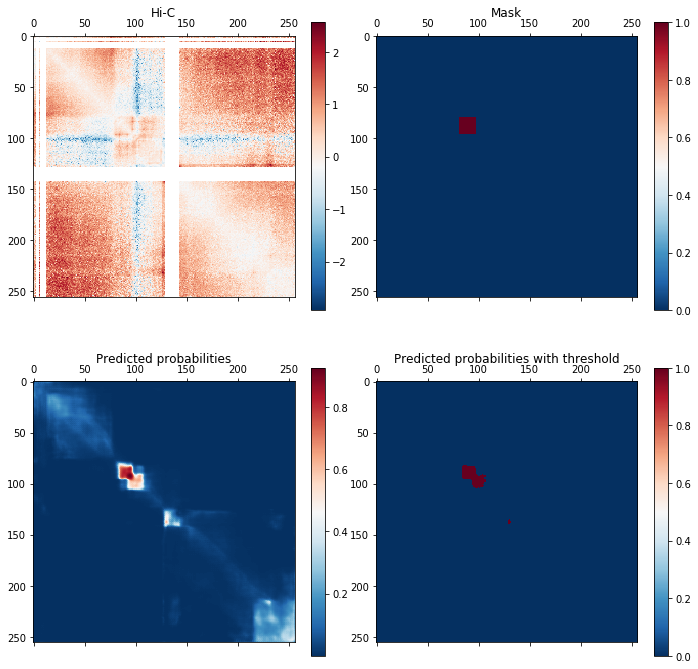

In [13]:
print('Train example 1')
loops_utils.plot_prediction_HiC(X_train[1,:,:,:],
                                y_train[1,:,:,:],
                                preds_train[1,:,:,:],
                                preds_train_t[1,:,:,:],
                                image_size=256,
                                name='Unet_rao_256_train_pred_1')

Test example 1


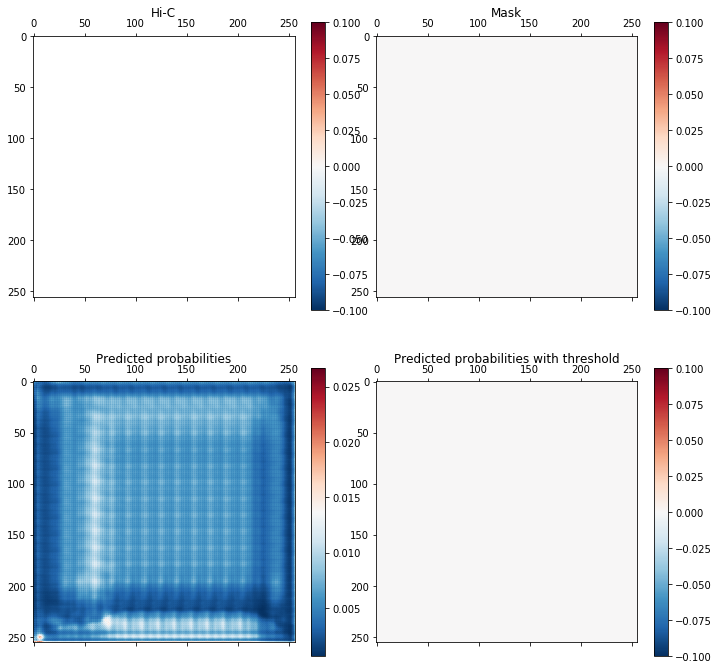

In [14]:
print('Test example 1')
loops_utils.plot_prediction_HiC(X_test[40,:,:,:],
                                y_test[40,:,:,:],
                                preds_test[40,:,:,:],
                                preds_test_t[40,:,:,:],
                                image_size=256,
                                name='Unet_rao_256_test_pred_1')

Test example 2


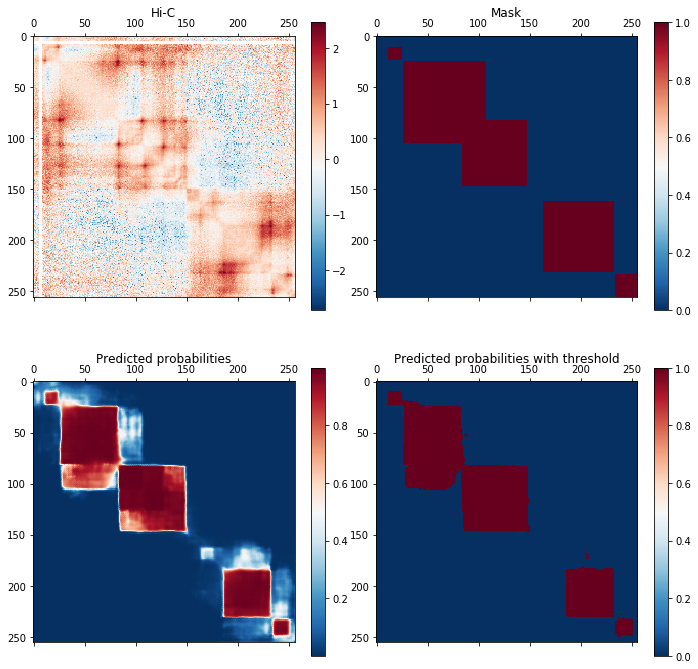

In [17]:
print('Test example 2')
loops_utils.plot_prediction_HiC(X_test[30,:,:,:],
                                y_test[30,:,:,:],
                                preds_test[30,:,:,:],
                                preds_test_t[30,:,:,:],
                                image_size=256,
                                name='Unet_rao_256_test_pred_2')

## select mask with corner peaks only